In [1]:
import numpy as np
import pandas as pd

In [6]:
trails = pd.read_csv("WebProject.csv", encoding = 'mac_roman' )

trails.shape

trails.head()

trails.dtypes

Unnamed: 0          int64
Trail_Name         object
Rank                int64
Difficulty         object
Distance_Miles    float64
Elevation_Feet      int64
Route_Type         object
Description        object
dtype: object

In [9]:
sum(trails.isnull().values)

#No missing values

array([0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

In [19]:
ntrails = trails.iloc[:,3:7]

ntrailsonehot = trails.loc[:, ['Difficulty', 'Route_Type']]

ntrailsonehot.head()

,Difficulty,Route_Type
0,Hard,Loop
1,Hard,Loop
2,Moderate,Out & Back
3,Hard,Loop
4,Moderate,Loop


In [36]:
encode = preprocessing.OneHotEncoder()

# 2. Fit the encoder
encode.fit(ntrailsonehot)

# 3. Transform to binary columns
onehotlabels = encode.transform(ntrailsonehot).toarray()
onehotlabels.shape
onehotlabels


array([[0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0.]])

In [40]:
newcols = ['Cat1a', 'Cat1b', 'Cat1c', 'Cat2a', 'Cat2b', 'Cat2c']
catvardf = pd.DataFrame(onehotlabels, columns = newcols)

catvardf.shape

(1196, 6)

In [41]:
other_trails = trails.loc[:, ['Distance_Miles', 'Elevation_Feet']]



In [44]:
X = pd.concat((other_trails, catvardf), axis = 1)
X.shape

(1196, 8)

In [48]:
from sklearn.covariance import EllipticEnvelope
outlier_frac = 0.02

ell = EllipticEnvelope(contamination = outlier_frac)
ell.fit(X)

C:\Users\Jordan\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


EllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,
         store_precision=True, support_fraction=None)

In [49]:
#Checking for the number of outliers

pred = ell.predict(X)
print(sum(pred == -1) ) # Outlier points are predicted as -1
stats.itemfreq(pred)



24


C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """


array([[  -1,   24],
       [   1, 1172]], dtype=int64)

In [50]:
keep = pred == 1

Xkeep = X[keep]

print(Xkeep.shape)
Xkeep.head()

(1172, 8)


,Distance_Miles,Elevation_Feet,Cat1a,Cat1b,Cat1c,Cat2a,Cat2b,Cat2c
0,8.6,3822,0.0,1.0,0.0,1.0,0.0,0.0
1,4.0,1751,0.0,1.0,0.0,1.0,0.0,0.0
2,3.2,905,0.0,0.0,1.0,0.0,1.0,0.0
3,3.7,1768,0.0,1.0,0.0,1.0,0.0,0.0
4,3.7,1148,0.0,0.0,1.0,1.0,0.0,0.0


In [51]:
scaler = StandardScaler()

ready_to_clusterstd = scaler.fit_transform(Xkeep)

C:\Users\Jordan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jordan\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [57]:
from sklearn.decomposition import PCA

pca = PCA(0.90)
pca.fit(ready_to_clusterstd)

pca.n_components_

4

In [62]:
pca_components = pca.transform(ready_to_clusterstd)
pca_components.shape

(1172, 4)

In [63]:
Xkeep["index"] = Xkeep.index
Xkeep2 = Xkeep.reset_index()
Xkeep2.head()

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,level_0,Distance_Miles,Elevation_Feet,Cat1a,Cat1b,Cat1c,Cat2a,Cat2b,Cat2c,Cluster_number,index
0,0,8.6,3822,0.0,1.0,0.0,1.0,0.0,0.0,5,0
1,1,4.0,1751,0.0,1.0,0.0,1.0,0.0,0.0,0,1
2,2,3.2,905,0.0,0.0,1.0,0.0,1.0,0.0,4,2
3,3,3.7,1768,0.0,1.0,0.0,1.0,0.0,0.0,0,3
4,4,3.7,1148,0.0,0.0,1.0,1.0,0.0,0.0,4,4


In [67]:
cols = []
for i in range (1, 5):
    cols.append("PC" + str(i))

print(cols)

PCdf = pd.DataFrame(pca_components, columns = cols, index  =  Xkeep.index)
PCdf.head()

['PC1', 'PC2', 'PC3', 'PC4']


,PC1,PC2,PC3,PC4
0,1.806126,1.863293,0.369014,-1.105734
1,0.615717,1.602426,0.186959,-1.035805
2,-0.328563,-2.056302,0.635481,0.283673
3,0.589411,1.595684,0.182455,-1.039491
4,-0.911413,0.440869,1.837406,0.142946


In [68]:

labels = []
for i in range(5,13):
    kmeans = KMeans(n_clusters= i)
    kmeans = kmeans.fit(PCdf)
    labelPCdf = kmeans.labels_
    labels.append(labelPCdf)
    centroids = kmeans.cluster_centers_
    centroids[:, 0]
    print(stats.itemfreq(labelPCdf))
   


C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and 

[[  0 244]
 [  1 232]
 [  2 284]
 [  3  49]
 [  4 363]]
[[  0 232]
 [  1 140]
 [  2  49]
 [  3 244]
 [  4 284]
 [  5 223]]
[[  0 223]
 [  1 165]
 [  2 229]
 [  3  49]
 [  4 241]
 [  5 140]
 [  6 125]]
[[  0 140]
 [  1 229]
 [  2 125]
 [  3 223]
 [  4 241]
 [  5 165]
 [  6  35]
 [  7  14]]


C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  # Remove the CWD from sys.path while we load stuff.


[[  0 229]
 [  1 129]
 [  2 223]
 [  3 241]
 [  4  35]
 [  5 140]
 [  6 125]
 [  7  36]
 [  8  14]]
[[  0 241]
 [  1 223]
 [  2  87]
 [  3 140]
 [  4  35]
 [  5 229]
 [  6 127]
 [  7  14]
 [  8  38]
 [  9  38]]
[[  0 229]
 [  1  38]
 [  2 185]
 [  3 223]
 [  4  87]
 [  5  35]
 [  6 140]
 [  7  14]
 [  8 124]
 [  9  59]
 [ 10  38]]
[[  0 186]
 [  1 126]
 [  2 223]
 [  3 180]
 [  4  35]
 [  5 140]
 [  6  84]
 [  7  14]
 [  8  36]
 [  9  46]
 [ 10  64]
 [ 11  38]]


C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  # Remove the CWD from sys.path while we load stuff.


In [69]:
print(labels[1])

[4 4 3 ... 4 4 5]


In [70]:
#Let's go with 6 cluster groups
whole_cluster = labels[1]
whole_cluster.view()

PCdf["Cluster_number"] = whole_cluster
print(PCdf.head())
PCdf["Cluster_number"].value_counts()

        PC1       PC2       PC3       PC4  Cluster_number
0  1.806126  1.863293  0.369014 -1.105734               4
1  0.615717  1.602426  0.186959 -1.035805               4
2 -0.328563 -2.056302  0.635481  0.283673               3
3  0.589411  1.595684  0.182455 -1.039491               4
4 -0.911413  0.440869  1.837406  0.142946               0


4    284
3    244
0    232
5    223
1    140
2     49
Name: Cluster_number, dtype: int64

In [72]:
completetrails = pd.concat([trails, PCdf], axis = 1)
completetrails.tail()

,Unnamed: 0,Trail_Name,Rank,Difficulty,Distance_Miles,Elevation_Feet,Route_Type,Description,PC1,PC2,PC3,PC4,Cluster_number
1191,1192,Oregon Mountain Loop [PRIVATE PROPERTY],1192,Easy,3.2,1200,Loop,Oregon Mountain Loop [PRIVATE PROPERTY] is a 3...,-1.473265,1.505453,-0.753901,-0.152504,5.0
1192,1193,Mowgli's Mountain Loop [PRIVATE PROPERTY],1193,Moderate,6.7,1870,Loop,Mowgli's Mountain Loop [PRIVATE PROPERTY] is a...,-0.347263,0.568539,1.925673,0.131432,0.0
1193,1194,Cardigan via Back 80 & Mowgli's Trails [PRIVAT...,1194,Hard,9.9,3047,Out & Back,Cardigan via Back 80 & Mowgli's Trails [PRIVAT...,2.401659,-0.622467,-0.826724,-0.919570,4.0
1194,1195,Mount Chocorua via Liberty Trail to Bee Line T...,1195,Hard,7.6,2539,Loop,Mount Chocorua via Liberty Trail to Bee Line T...,1.266232,1.750335,0.289081,-1.045369,4.0
1195,1196,Skyview to Gumpus Hill Loop,1196,Easy,2.1,206,Loop,Skyview to Gumpus Hill Loop is a 2.1 mile mode...,-1.926286,1.409384,-0.821605,-0.108733,5.0


In [77]:
completetrails.to_csv("ClusteredTrails.csv")

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)

ValueError: color kwarg must have one color per data set. 232 data sets and 1 colors were provided

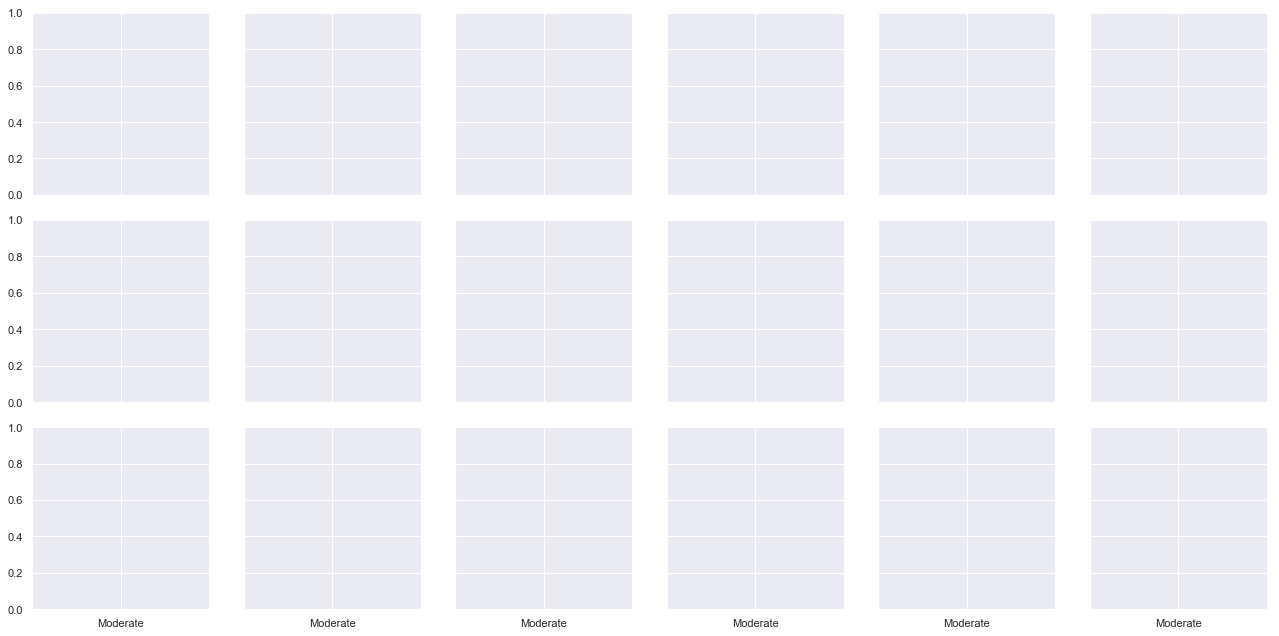

In [76]:
import seaborn as sns
#Visualization
g = sns.FacetGrid(completetrails, row="Route_Type", col="Cluster_number", margin_titles=True, hue="Cluster_number")
g.map(plt.hist, "Difficulty")